In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import inflect
import contractions
from bs4 import BeautifulSoup
import unicodedata
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import re

In [12]:
df = pd.read_csv("./Journal Entries with Labelled Emotions Multi Lable.csv")
df.head()

,Answer,Answer.f1.afraid.raw,Answer.f1.angry.raw,Answer.f1.anxious.raw,Answer.f1.ashamed.raw,Answer.f1.awkward.raw,Answer.f1.bored.raw,Answer.f1.calm.raw,Answer.f1.confused.raw,Answer.f1.disgusted.raw,...,Answer.t1.family.raw,Answer.t1.food.raw,Answer.t1.friends.raw,Answer.t1.god.raw,Answer.t1.health.raw,Answer.t1.love.raw,Answer.t1.recreation.raw,Answer.t1.school.raw,Answer.t1.sleep.raw,Answer.t1.work.raw
0,"My family was the most salient part of my day,...",False,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,Yoga keeps me focused. I am able to take some ...,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,"Yesterday, my family and I played a bunch of b...",False,False,False,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False
3,"Yesterday, I visited my parents and had dinner...",False,False,False,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False
4,"Yesterday, I really felt the importance of my ...",False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [13]:
selected_columns = df.columns[:19]
df = df[selected_columns]

In [21]:
new_columns = [col.replace('Answer.f1.', '') for col in df.columns]
df.columns = new_columns

new_columns = [col.replace('.raw', '') for col in df.columns]
df.columns = new_columns

new_columns = [col.replace('Answer', 'text') for col in df.columns]
df.columns = new_columns

df = df.replace({False: 0, True: 1})

df.head()

,text,afraid,angry,anxious,ashamed,awkward,bored,calm,confused,disgusted,excited,frustrated,happy,jealous,nostalgic,proud,sad,satisfied,surprised
0,"My family was the most salient part of my day,...",0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,Yoga keeps me focused. I am able to take some ...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,"Yesterday, my family and I played a bunch of b...",0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,"Yesterday, I visited my parents and had dinner...",0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,"Yesterday, I really felt the importance of my ...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [22]:
def text_preprocessing_platform(df, text_col, remove_stopwords=True):
    
    ## Define functions for individual steps
    # First function is used to denoise text
    def denoise_text(text):
        # Strip html if any. For ex. removing <html>, <p> tags
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()
        # Replace contractions in the text. For ex. didn't -> did not
        text = contractions.fix(text)
        return text
    
    ## Next step is text-normalization
    
    # Text normalization includes many steps.
    
    # Each function below serves a step.
    
    
    def remove_non_ascii(words):
        """Remove non-ASCII characters from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        return new_words
    
    
    def to_lowercase(words):
        """Convert all characters to lowercase from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = word.lower()
            new_words.append(new_word)
        return new_words
    
    
    def remove_punctuation(words):
        """Remove punctuation from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words
    
    
    def replace_numbers(words):
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        p = inflect.engine()
        new_words = []
        for word in words:
            if word.isdigit():
                new_word = p.number_to_words(word)
                new_words.append(new_word)
            else:
                new_words.append(word)
        return new_words
    
    
    def remove_stopwords(words):
        """Remove stop words from list of tokenized words"""
        new_words = []
        for word in words:
            if word not in stopwords.words('english'):
                new_words.append(word)
        return new_words
    
    
    def stem_words(words):
        """Stem words in list of tokenized words"""
        stemmer = LancasterStemmer()
        stems = []
        for word in words:
            stem = stemmer.stem(word)
            stems.append(stem)
        return stems
    
    
    def lemmatize_verbs(words):
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer()
        lemmas = []
        for word in words:
            lemma = lemmatizer.lemmatize(word, pos='v')
            lemmas.append(lemma)
        return lemmas
    
    
    ### A wrap-up function for normalization
    def normalize_text(words, remove_stopwords):
        words = remove_non_ascii(words)
        words = to_lowercase(words)
        words = remove_punctuation(words)
        words = replace_numbers(words)
        if remove_stopwords:
            words = remove_stopwords(words)
        #words = stem_words(words)
        words = lemmatize_verbs(words)
        return words
    
    # All above functions work on word tokens we need a tokenizer
    
    # Tokenize tweet into words
    def tokenize(text):
        return nltk.word_tokenize(text)
    
    
    # A overall wrap-up function
    def text_prepare(text):
        text = denoise_text(text)
        print("After Denoise:", text)
        # text = ' '.join([x for x in normalize_text(tokenize(text), remove_stopwords)])
        # return text
        words = normalize_text(tokenize(text), remove_stopwords)
    
    # Check if the list of words is empty
        if not words:
            # Handle empty text
            return ''
        
        # Join the non-empty list of words
        text = ' '.join(words)
        return text
    
    import re

    
    
    # run every-step
    df[text_col] = [text_prepare(x) for x in df[text_col]]
    
    
    # return processed df
    return df

In [23]:
def text_preprocessing_platform(df, text_col, remove_stopwords=True):
    def denoise_and_tokenize(text):
        # Strip HTML tags and replace contractions
        soup = BeautifulSoup(text, "html.parser")
        text = contractions.fix(soup.get_text())
        # Tokenize tweet into words
        return nltk.word_tokenize(text)

    def remove_non_ascii(words):
        return [unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore') for word in words]

    def normalize_text(words, remove_stopwords):
        words = remove_non_ascii(words)
        words = [word.lower() for word in words]
        words = [re.sub(r'[^\w\s]', '', word) for word in words if word != '']
        words = [inflect.engine().number_to_words(word) if word.isdigit() else word for word in words]
        if remove_stopwords:
            stop_words = set(stopwords.words('english'))
            words = [word for word in words if word not in stop_words]
        words = lemmatize_verbs(words)
        return words

    def lemmatize_verbs(words):
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(word, pos='v') for word in words]

    def text_prepare(text):
        words = normalize_text(denoise_and_tokenize(text), remove_stopwords)
        return ' '.join(words) if words else ''

    df[text_col] = [text_prepare(x) for x in df[text_col]]
    return df

In [24]:
print("Before Text Preprocessing")
display(df.head()[['text']])
processed_df1 = text_preprocessing_platform(df, 'text', remove_stopwords=False)
print("After Text Preprocessing")
display(processed_df1.head()[['text']])

Before Text Preprocessing


,text
0,"My family was the most salient part of my day,..."
1,Yoga keeps me focused. I am able to take some ...
2,"Yesterday, my family and I played a bunch of b..."
3,"Yesterday, I visited my parents and had dinner..."
4,"Yesterday, I really felt the importance of my ..."


C:\Users\Soumya\AppData\Local\Temp\ipykernel_3280\3785908740.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


After Text Preprocessing


,text
0,my family be the most salient part of my day ...
1,yoga keep me focus i be able to take some tim...
2,yesterday my family and i play a bunch of boa...
3,yesterday i visit my parent and have dinner w...
4,yesterday i really felt the importance of my ...


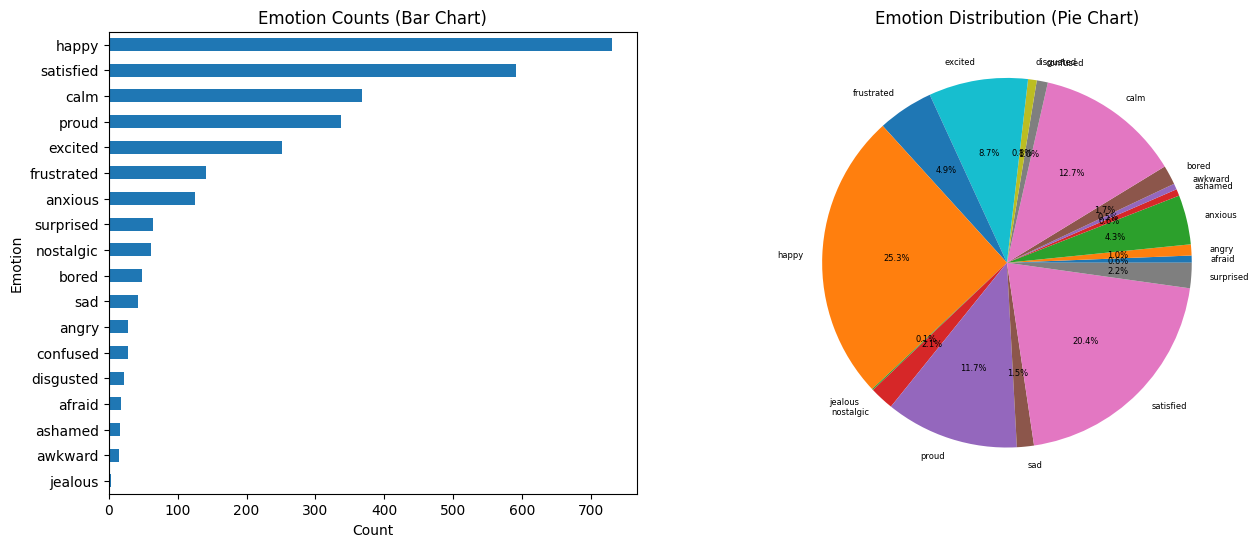

In [25]:
emotion_counts = processed_df1.iloc[:, 1:].sum()

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot bar chart
emotion_counts.sort_values().plot(kind='barh', ax=axes[0])
axes[0].set_title('Emotion Counts (Bar Chart)')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Emotion')

# Plot pie chart
emotion_counts.plot(kind='pie', autopct='%1.1f%%', ax=axes[1], fontsize=6)
axes[1].set_title('Emotion Distribution (Pie Chart)')

# Display the plots
plt.show()

In [26]:
processed_df1.to_csv('processed_data.csv', index=False)